In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

C:\Users\91889\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## 1.1 Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv', nrows=5000)
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (5000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

# 1.2 Data Analysis

Number of projects thar are approved for funding  4237 , ( 84.74000000000001 %)
Number of projects thar are not approved for funding  763 , ( 15.260000000000002 %)


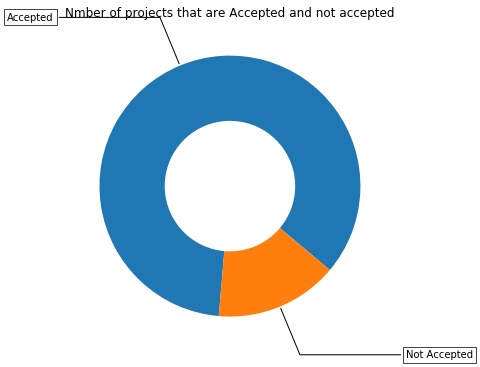

In [5]:
# PROVIDE CITATIONS TO YOUR CODE IF YOU TAKE IT FROM ANOTHER WEBSITE.
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = project_data['project_is_approved'].value_counts()
print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

### Observation

The pie chart shows that a maximum number of projects getting submitted gets approved with the ratio of approved to not approved being [17:3].


### 1.2.1 Univariate Analysis: School State

In [6]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()

# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['state_code', 'num_proposals']

# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')


In [7]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.500000
41         SD       0.687500
7          DC       0.695652
0          AK       0.705882
50         WY       0.777778
States with highest % approvals
   state_code  num_proposals
11         HI       0.964286
16         KS       0.966667
28         ND       1.000000
8          DE       1.000000
30         NH       1.000000


In [8]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [9]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

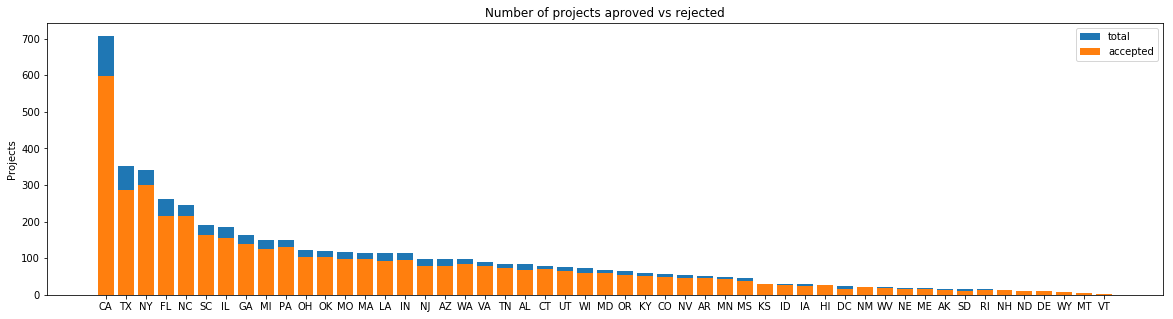

   school_state  project_is_approved  total       Avg
4            CA                  597    707  0.844413
43           TX                  286    352  0.812500
34           NY                  299    342  0.874269
9            FL                  215    261  0.823755
27           NC                  216    246  0.878049
   school_state  project_is_approved  total       Avg
28           ND                   11     11  1.000000
8            DE                   11     11  1.000000
50           WY                    7      9  0.777778
26           MT                    5      6  0.833333
46           VT                    1      2  0.500000


In [10]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

### Observation

The bar plot showcases the trend of projects getting submitted and the ones getting accepted statewise. There is a proportional trend with the 2 parameters.

__SUMMARY: Every state has greater than 80% success rate in approval__

### 1.2.2 Univariate Analysis: teacher_prefix

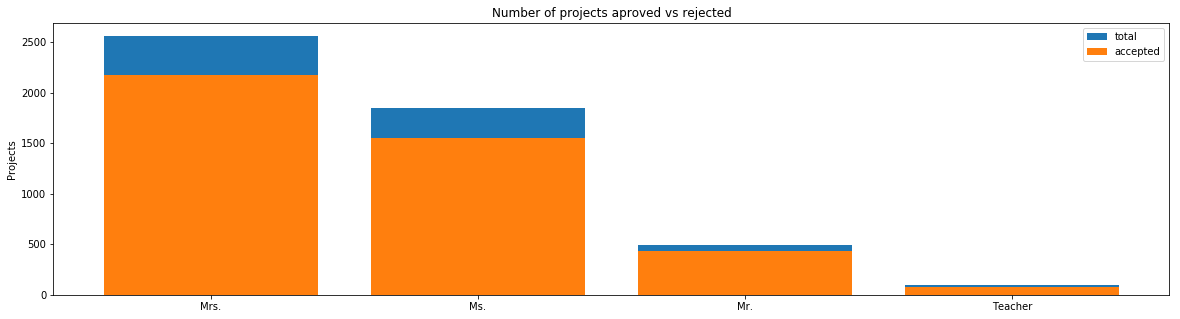

  teacher_prefix  project_is_approved  total       Avg
1           Mrs.                 2173   2560  0.848828
2            Ms.                 1554   1845  0.842276
0            Mr.                  433    495  0.874747
3        Teacher                   77    100  0.770000
  teacher_prefix  project_is_approved  total       Avg
1           Mrs.                 2173   2560  0.848828
2            Ms.                 1554   1845  0.842276
0            Mr.                  433    495  0.874747
3        Teacher                   77    100  0.770000


In [11]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

### Observation

The bar plot showcases the trend of projects getting submitted and the ones getting accepted according to teacher prefix. There is a clear difference between the projects getting approved and the ones getting rejected. Former count is much greater than the latter.

### 1.2.3 Univariate Analysis: project_grade_category

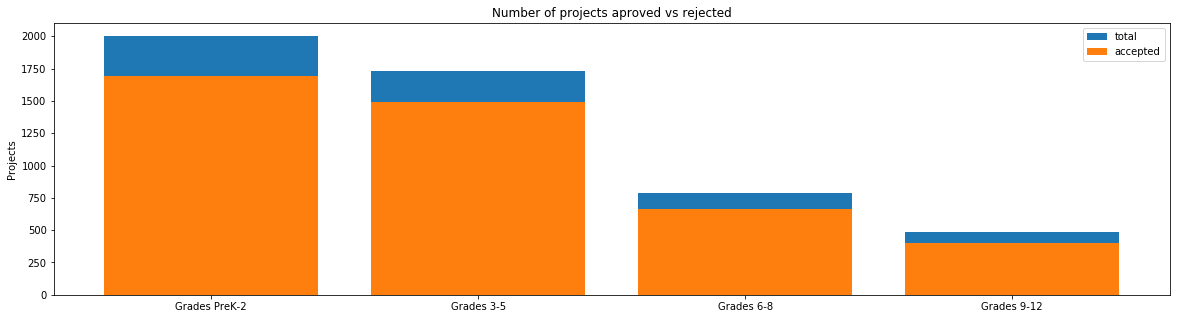

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                 1689   2002  0.843656
0             Grades 3-5                 1491   1729  0.862348
1             Grades 6-8                  660    785  0.840764
2            Grades 9-12                  397    484  0.820248
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                 1689   2002  0.843656
0             Grades 3-5                 1491   1729  0.862348
1             Grades 6-8                  660    785  0.840764
2            Grades 9-12                  397    484  0.820248


In [12]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)

### Observation

The bar plot showcases the trend of projects getting submitted and the ones getting accepted on the basis of project grade category. There is a proportional trend with the 2 parameters.

### 1.2.4 Univariate Analysis: project_subject_categories

In [13]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [14]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN           05-12-2016 13:43          Grades PreK-2   
1           FL           25-10-2016 09:22             Grades 6-8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

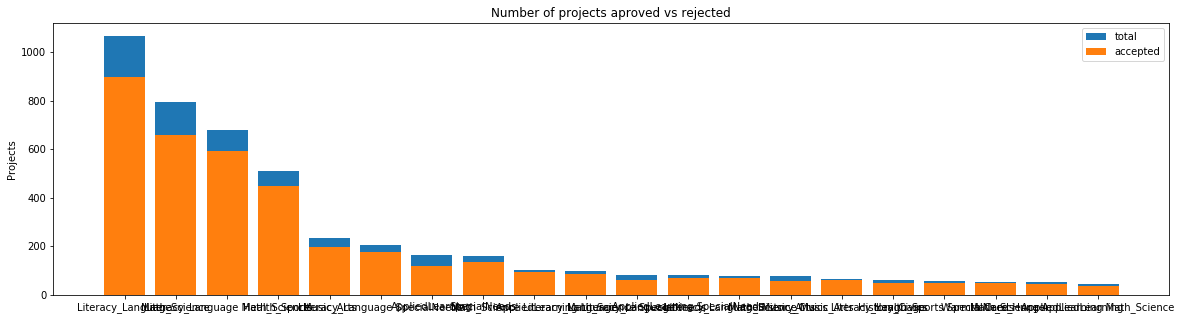

                  clean_categories  project_is_approved  total       Avg
23               Literacy_Language                  900   1067  0.843486
30                    Math_Science                  659    795  0.828931
26  Literacy_Language Math_Science                  594    679  0.874816
8                    Health_Sports                  447    509  0.878193
37                      Music_Arts                  199    233  0.854077
                clean_categories  project_is_approved  total       Avg
16                History_Civics                   47     63  0.746032
14    Health_Sports SpecialNeeds                   49     57  0.859649
46            Warmth Care_Hunger                   47     53  0.886792
31  Math_Science AppliedLearning                   44     52  0.846154
4   AppliedLearning Math_Science                   35     44  0.795455


In [15]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

In [92]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

## Summary

There is a proportional trend between the projects submitted and the ones getting approved among all the features. Also, most number of projects gets accepted with the accaptance rate being more than 70% if we take the 'sunject category' as a feature to analyse.

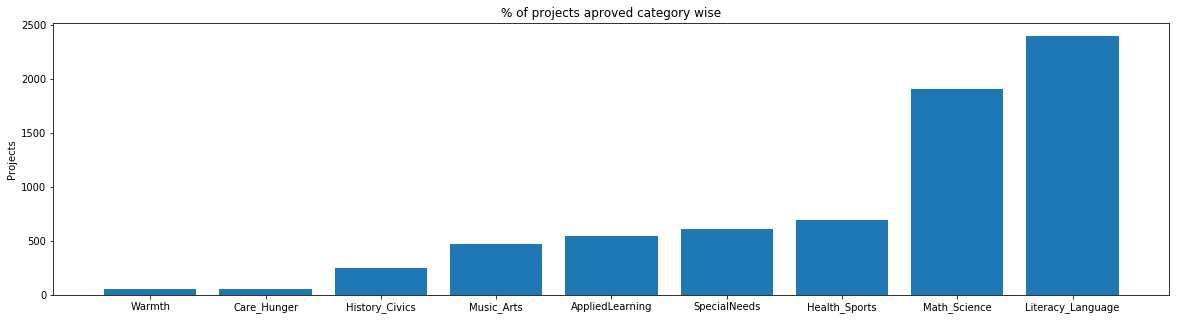

In [17]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))
  

ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

### Observation

The projects submitted under Literacy Language has the maximum approval percentage.

In [18]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :        58
Care_Hunger          :        58
History_Civics       :       252
Music_Arts           :       476
AppliedLearning      :       547
SpecialNeeds         :       614
Health_Sports        :       697
Math_Science         :      1910
Literacy_Language    :      2400


### 1.2.5 Univariate Analysis: project_subject_subcategories

In [19]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [20]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN           05-12-2016 13:43          Grades PreK-2   
1           FL           25-10-2016 09:22             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

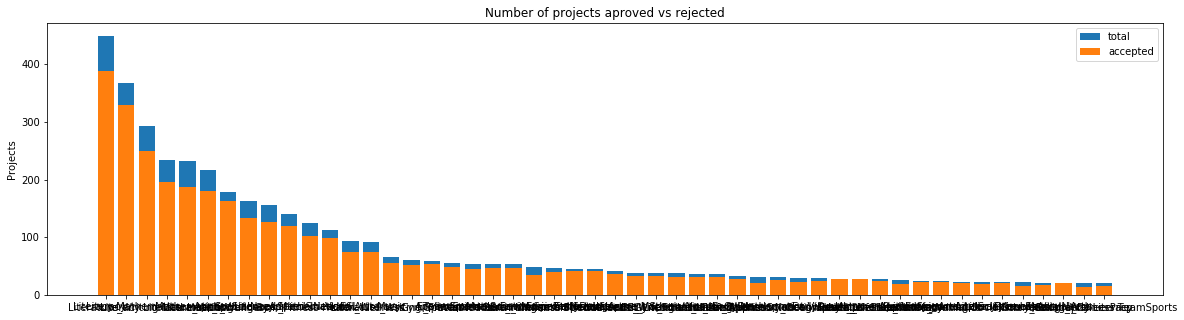

                clean_subcategories  project_is_approved  total       Avg
189                        Literacy                  389    449  0.866370
191            Literacy Mathematics                  329    368  0.894022
201  Literature_Writing Mathematics                  250    293  0.853242
190     Literacy Literature_Writing                  195    234  0.833333
209                     Mathematics                  188    232  0.810345
            clean_subcategories  project_is_approved  total       Avg
23   AppliedSciences VisualArts                   15     22  0.681818
230          Other SpecialNeeds                   17     21  0.809524
181  History_Geography Literacy                   20     21  0.952381
56           College_CareerPrep                   14     20  0.700000
177  Health_Wellness TeamSports                   15     20  0.750000


In [21]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)

In [22]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

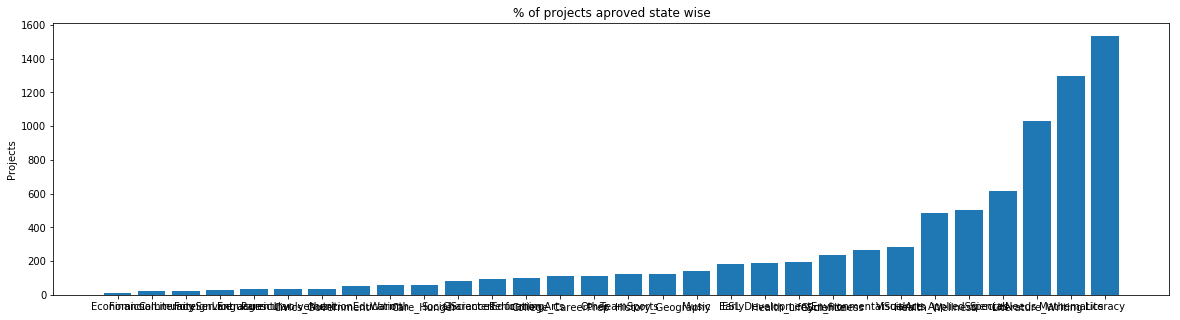

In [23]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [24]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :        14
FinancialLiteracy    :        23
CommunityService     :        26
ForeignLanguages     :        29
Extracurricular      :        33
ParentInvolvement    :        34
Civics_Government    :        36
NutritionEducation   :        54
Warmth               :        58
Care_Hunger          :        58
SocialSciences       :        82
CharacterEducation   :        95
PerformingArts       :       102
College_CareerPrep   :       113
Other                :       114
TeamSports           :       123
History_Geography    :       124
Music                :       142
ESL                  :       182
EarlyDevelopment     :       189
Health_LifeScience   :       196
Gym_Fitness          :       237
EnvironmentalScience :       265
VisualArts           :       282
Health_Wellness      :       486
AppliedSciences      :       504
SpecialNeeds         :       614
Literature_Writing   :      1032
Mathematics          :      1295
Literacy             :      1534


### 1.2.6 Univariate Analysis: Text features (Title)

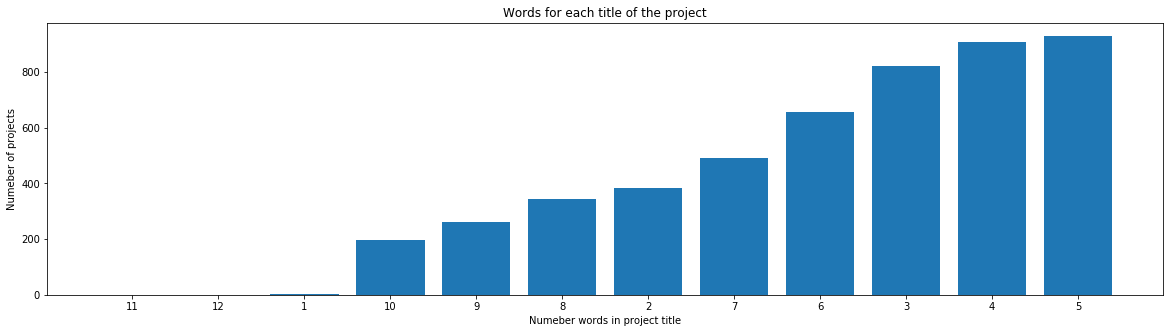

In [25]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.xlabel('Numeber words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

### Observation

Most number of projects submitted have title words in the range[3 to 7] with 5 words being the most common.

In [26]:
approved_title_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

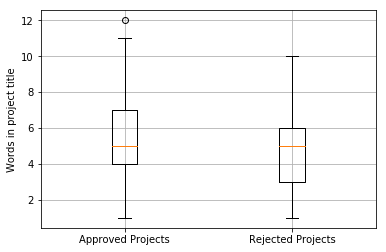

In [27]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

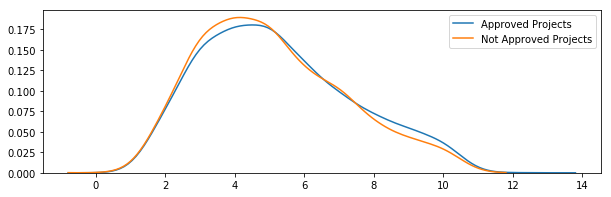

In [28]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

## Summary

With the above plots, it can be seen that the probability of project getting approved decreases with the decrease in the number of words in the title.

### 1.2.7 Univariate Analysis: Text features (Project Essay's)

In [29]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [30]:
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

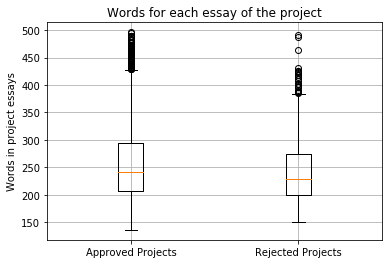

In [31]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')   
plt.grid()
plt.show()

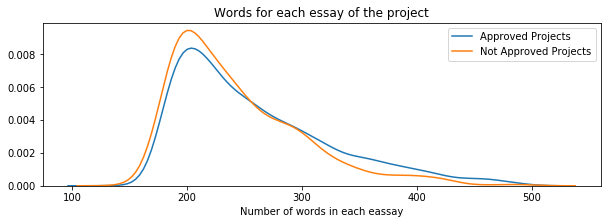

In [32]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

## Summary

With the above plots, it can be seen that the probability of project getting approved decreases with the decrease in the number of words in the essay. The approved project with the highest essay lenth is at around 200 words.

### 1.2.8 Univariate Analysis: Cost per project

In [33]:
# we get the cost of the project using resource.csv file
resource_data.head(5)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

In [34]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(5)

id    price  quantity
0  p000001   459.56         7
1  p000002   515.89        21
2  p000003   298.97         4
3  p000004  1113.69        98
4  p000005   485.99         8

In [35]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [36]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

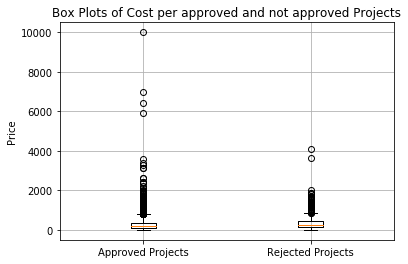

In [37]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show() 

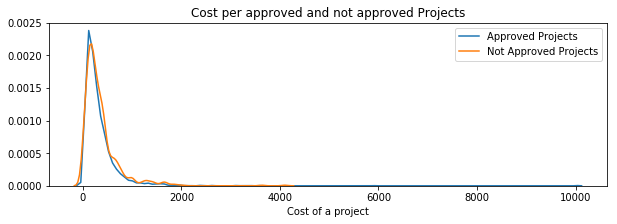

In [38]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

## Summary

We cannot really distinguish between the cost feature of the projects which are getting approved and those getting rejected. But it can be said that most of the projects are within the range of [1,2000]. The approved projects have a higher outlier and some cost goes upto 10000.

In [39]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        1.44       |          5.19         |
|     5      |       14.664      |         40.045        |
|     10     |       35.41       |         75.106        |
|     15     |       56.788      |        104.181        |
|     20     |       75.848      |        126.288        |
|     25     |       100.21      |        145.665        |
|     30     |      119.948      |        159.996        |
|     35     |       139.99      |        180.088        |
|     40     |       159.43      |        207.546        |
|     45     |       179.0       |        232.279        |
|     50     |       200.77      |         258.07        |
|     55     |      229.636      |        289.256        |
|     60     |      259.744      |        314.946        |
|     65     |      288.936      |        357.846       

<h3><font color='red'>1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects</font></h3>


univariate_barplots(project_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved', False)

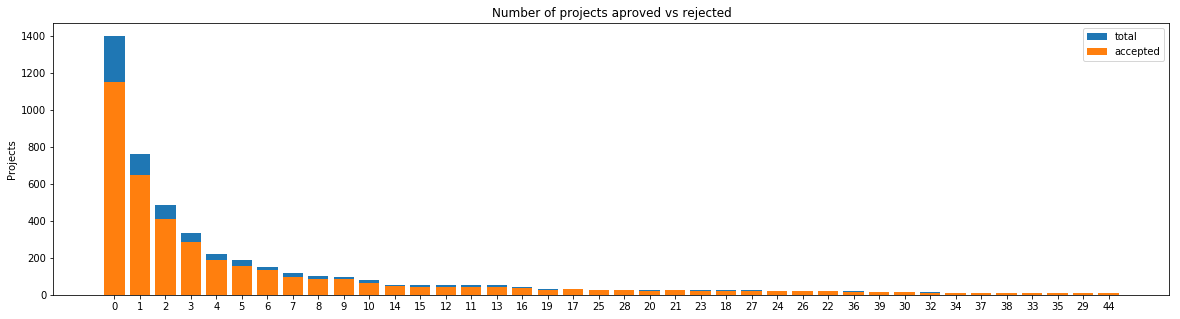

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                 1149   1399   
1                                             1                  646    760   
2                                             2                  409    486   
3                                             3                  288    335   
4                                             4                  186    221   

        Avg  
0  0.821301  
1  0.850000  
2  0.841564  
3  0.859701  
4  0.841629  
    teacher_number_of_previously_posted_projects  project_is_approved  total  \
38                                            38                   11     11   
33                                            33                   11     11   
35                                            35                    8     11   
29                                            29                   11     11   
44                                       

In [40]:
univariate_barplots(project_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved', top=40)


<h3><font color='red'>1.2.10 Univariate Analysis: project_resource_summary</font></h3>

Please do this on your own based on the data analysis that was done in the above cells

Check if the `presence of the numerical digits` in the `project_resource_summary` effects the acceptance of the project or not. If you observe that `presence of the numerical digits` is helpful in the classification, please include it for further process or you can ignore it.

In [41]:

project_summary_list=project_data['project_resource_summary'].tolist()
project_is_approved=project_data['project_is_approved'].tolist()

cnt1=0
cnt2=0
i=0
#print(project_summary_list)

while(i<len(project_summary_list)):
    def hasNumbers(project_summary_list):
         return any(char.isdigit() for char in project_summary_list[i])
    if True:
        if (project_is_approved[i]==1):
            cnt1+=1
        else:
            cnt2+=1    
    i+=1
        


print("projects approved which have digits in the summary = ", cnt1)
print("projects not approved which have digits in the summary = ", cnt2)


projects approved which have digits in the summary =  4237
projects not approved which have digits in the summary =  763


## Summary

We can see from the above output that the projects whose summary contained digits out of all submitted have an approval ratio of 7:10.

#### Note : There is an error in the above code as I am getting all values as True which is incorrect. Please help me find the solution.

## 1.3 Text preprocessing

### 1.3.1 Essay Text

In [42]:
project_data.head(5)


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN           05-12-2016 13:43          Grades PreK-2   
1           FL           25-10-2016 09:22             Grades 6-8   
2           AZ           31-08-2016 12:03             Grades 6-8   
3           KY           06-10-2016 21:16          Grades PreK-2   
4           TX           11-07-2016 01:10          Grades PreK-2   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   
2                                             1                    0   
3                                             4                    1   
4                                             1                    1   

                 clean_categories           clean_subcategories  \
0               Literacy_Language                  ESL Literacy   
1    History_Civics Health_Sports  Civics_Government TeamSports   
2                   Health_Sports    Health_Wellness TeamSports   
3  Literacy_Language Math_Science          Literacy Mathematics   
4                    Math_Science                   Mathematics   

                                               essay   price  quantity  
0  My students are English learners that are work...  154.60        23  
1  Our students arrive to our school eager to lea...  299.00         1  
2  \r\n\"True champions aren't always the ones th...  516.85        22  
3  I work at a unique school filled with both ESL...  232.90         4  
4  Our second grade classroom next year will be m...   67.98         4

In [43]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[350])
print("="*50)
print(project_data['essay'].values[1500])
print("="*50)
print(project_data['essay'].values[3000])
print("="*50)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [44]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [45]:
sent = decontracted(project_data['essay'].values[1000])
print(sent)
print("="*50)

How do you remember your days of school? Was it in a sterile environment with plain walls, rows of desks, and a teacher in front of the room? A typical day in our room is nothing like that. I work hard to create a warm inviting themed room for my students look forward to coming to each day.\r\n\r\nMy class is made up of 28 wonderfully unique boys and girls of mixed races in Arkansas.\r\nThey attend a Title I school, which means there is a high enough percentage of free and reduced-price lunch to qualify. Our school is an \"open classroom\" concept, which is very unique as there are no walls separating the classrooms. These 9 and 10 year-old students are very eager learners; they are like sponges, absorbing all the information and experiences and keep on wanting more.With these resources such as the comfy red throw pillows and the whimsical nautical hanging decor and the blue fish nets, I will be able to help create the mood in our classroom setting to be one of a themed nautical enviro

In [46]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

How do you remember your days of school? Was it in a sterile environment with plain walls, rows of desks, and a teacher in front of the room? A typical day in our room is nothing like that. I work hard to create a warm inviting themed room for my students look forward to coming to each day.    My class is made up of 28 wonderfully unique boys and girls of mixed races in Arkansas.  They attend a Title I school, which means there is a high enough percentage of free and reduced-price lunch to qualify. Our school is an  open classroom  concept, which is very unique as there are no walls separating the classrooms. These 9 and 10 year-old students are very eager learners; they are like sponges, absorbing all the information and experiences and keep on wanting more.With these resources such as the comfy red throw pillows and the whimsical nautical hanging decor and the blue fish nets, I will be able to help create the mood in our classroom setting to be one of a themed nautical environment. C

In [47]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

How do you remember your days of school Was it in a sterile environment with plain walls rows of desks and a teacher in front of the room A typical day in our room is nothing like that I work hard to create a warm inviting themed room for my students look forward to coming to each day My class is made up of 28 wonderfully unique boys and girls of mixed races in Arkansas They attend a Title I school which means there is a high enough percentage of free and reduced price lunch to qualify Our school is an open classroom concept which is very unique as there are no walls separating the classrooms These 9 and 10 year old students are very eager learners they are like sponges absorbing all the information and experiences and keep on wanting more With these resources such as the comfy red throw pillows and the whimsical nautical hanging decor and the blue fish nets I will be able to help create the mood in our classroom setting to be one of a themed nautical environment Creating a classroom e

In [48]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [49]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 846.24it/s]


In [50]:
# after preprocesing
preprocessed_essays[10]

'there many little ways enlarge world love books best jacqueline kennedy i work title 1 school serves students lower income families they often enter 5th grade reading second grade level notion reading another thing not good i provide motivation want pick book snuggle bean bag read ever lifetime i 8 sets students enjoy books classroom library throughout past years result falling apart it testament much loved reading unfortunately books soon need retired with purchase new books ensure joy reading continues past school year a haunted mystery series word mouse the babysitters club books students would love read my students struggle building vocabulary time reach 5th grade no interest picking book i determined change futures sharing joy reading reading allows make connections beyond limited world gives gateway limitless opportunities your donations help improve classroom library tangible evidence students i not one thinks reading changes lives nannan'

<h3><font color='red'>1.3.2 Project title Text</font></h3>

In [51]:
# printing some random essays.
print(project_data['project_title'].values[0])
print("="*50)
print(project_data['project_title'].values[150])
print("="*50)
print(project_data['project_title'].values[500])
print("="*50)
print(project_data['project_title'].values[2500])
print("="*50)
print(project_data['project_title'].values[4999])
print("="*50)

Educational Support for English Learners at Home
More Movement with Hokki Stools
Classroom Chromebooks for College Bound Seniors!
Food for the Brain!
SOCK IT OUT IN BASKETBALL


In [52]:
# similarly you can preprocess the titles also


preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    title = decontracted(sentance)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    # https://gist.github.com/sebleier/554280
    title = ' '.join(e for e in title.split() if e not in stopwords)
    preprocessed_titles.append(title.lower().strip())
    


100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 27564.62it/s]


In [53]:
preprocessed_titles[1000]

'sailing into super 4th grade year'

## 1. 4 Preparing data for models

In [54]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price',
       'quantity'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data
       
       - quantity : numerical
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 1.4.1 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

In [55]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())


clean_categories_one_hot = vectorizer.transform(project_data['clean_categories'].values)
print("Shape of matrix after one hot encodig ",clean_categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (5000, 9)


In [56]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())


clean_subcategories_one_hot = vectorizer.transform(project_data['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",clean_subcategories_one_hot.shape)

['Economics', 'FinancialLiteracy', 'CommunityService', 'ForeignLanguages', 'Extracurricular', 'ParentInvolvement', 'Civics_Government', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'CharacterEducation', 'PerformingArts', 'College_CareerPrep', 'Other', 'TeamSports', 'History_Geography', 'Music', 'ESL', 'EarlyDevelopment', 'Health_LifeScience', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (5000, 30)


In [57]:
# Please do the similar feature encoding with state, teacher_prefix and project_grade_category also

In [58]:

vectorizer = CountVectorizer()
vectorizer.fit(project_data['school_state'].values)
print(vectorizer.get_feature_names())


school_state_one_hot = vectorizer.transform(project_data['school_state'].values)
print("Shape of matrix after one hot encodig ",school_state_one_hot.shape)

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
Shape of matrix after one hot encodig  (5000, 51)


In [59]:

vectorizer = CountVectorizer()
vectorizer.fit(project_data['project_grade_category'].values)
print(vectorizer.get_feature_names())


project_grade_one_hot = vectorizer.transform(project_data['project_grade_category'].values)
print("Shape of matrix after one hot encodig ",project_grade_one_hot.shape)

['12', 'grades', 'prek']
Shape of matrix after one hot encodig  (5000, 3)


In [60]:
vectorizer = CountVectorizer()
vectorizer.fit(project_data['teacher_prefix'].values)
print(vectorizer.get_feature_names())


teacher_prefix_one_hot = vectorizer.transform(project_data['teacher_prefix'].values)
print("Shape of matrix after one hot encodig ",teacher_prefix_one_hot.shape)

['mr', 'mrs', 'ms', 'teacher']
Shape of matrix after one hot encodig  (5000, 4)


### 1.4.2 Vectorizing Text data

#### 1.4.2.1 Bag of words

In [61]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (5000, 4373)


<h4><font color='red'> 1.4.2.2 Bag of Words on `project_title`</font></h4>

In [62]:
# you can vectorize the title also 
# before you vectorize the title make sure you preprocess it

In [63]:
# Similarly you can vectorize for title also

In [64]:
vectorizer = CountVectorizer(min_df=10)
title_bow = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encodig ",title_bow.shape)

Shape of matrix after one hot encodig  (5000, 382)


#### 1.4.2.3 TFIDF vectorizer

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (5000, 4373)


<h4><font color='red'> 1.4.2.4 TFIDF Vectorizer on `project_title`</font></h4>

In [66]:
# Similarly you can vectorize for title also

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
title_tfidf = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encodig ",title_tfidf.shape)

Shape of matrix after one hot encodig  (5000, 382)


#### 1.4.2.5 Using Pretrained Models: Avg W2V

In [68]:
'''
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================
Output:
    
Loading Glove Model
1917495it [06:32, 4879.69it/s]
Done. 1917495  words loaded!

# ============================

words = []
for i in preproced_texts:
    words.extend(i.split(' '))

for i in preproced_titles:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)

'''


'\n# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039\ndef loadGloveModel(gloveFile):\n    print ("Loading Glove Model")\n    f = open(gloveFile,\'r\', encoding="utf8")\n    model = {}\n    for line in tqdm(f):\n        splitLine = line.split()\n        word = splitLine[0]\n        embedding = np.array([float(val) for val in splitLine[1:]])\n        model[word] = embedding\n    print ("Done.",len(model)," words loaded!")\n    return model\nmodel = loadGloveModel(\'glove.42B.300d.txt\')\n\n# ============================\nOutput:\n    \nLoading Glove Model\n1917495it [06:32, 4879.69it/s]\nDone. 1917495  words loaded!\n\n# ============================\n\nwords = []\nfor i in preproced_texts:\n    words.extend(i.split(\' \'))\n\nfor i in preproced_titles:\n    words.extend(i.split(\' \'))\nprint("all the words in the coupus", len(words))\nwords = set(words)\nprint("the unique words in the coupus", len(words))\n\ninter_words = set(model.keys()).intersection(word

In [69]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [70]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1705.38it/s]


5000
300


<h4><font color='red'> 1.4.2.6 Using Pretrained Models: AVG W2V on `project_title`</font></h4>

In [71]:
# Similarly you can vectorize for title also

In [72]:
avg_w2v_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title.append(vector)

print(len(avg_w2v_title))
print(len(avg_w2v_title[0]))

100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 42669.97it/s]


5000
300


#### 1.4.2.7 Using Pretrained Models: TFIDF weighted W2V

In [73]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [74]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:24<00:00, 207.65it/s]


5000
300


<h4><font color='red'> 1.4.2.9 Using Pretrained Models: TFIDF weighted W2V on `project_title`</font></h4>

In [75]:
# Similarly you can vectorize for title also

In [76]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_titles = set(tfidf_model.get_feature_names())

In [77]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_titles):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_titles.append(vector)

print(len(tfidf_w2v_titles))
print(len(tfidf_w2v_titles[0]))

100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 26364.68it/s]


5000
300


### 1.4.3 Vectorizing Numerical features

In [78]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

Mean : 302.78363, Standard deviation : 376.3799456048676


In [79]:
price_standardized

array([[-0.39370756],
       [-0.01005269],
       [ 0.56875073],
       ...,
       [-0.49814989],
       [-0.35127703],
       [-0.69826683]])

### 1.4.4 Merging all the above features

- we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [80]:
'''print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(text_bow.shape)
print(price_standardized.shape)
'''

'print(categories_one_hot.shape)\nprint(sub_categories_one_hot.shape)\nprint(text_bow.shape)\nprint(price_standardized.shape)\n'

In [81]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
#X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_standardized))
#X.shape

<h1><font color='red'>Assignment 2: Apply TSNE<font></h1>

 <font color=#F4274F>If you are using any code snippet from the internet, you have to provide the reference/citations, as we did in the above cells. Otherwise, it will be treated as plagiarism without citations.</font>

<ol> 
    <li> In the above cells we have plotted and analyzed many features. Please observe the plots and write the observations in markdown cells below every plot.</li>
    <li> EDA: Please complete the analysis of the feature: teacher_number_of_previously_posted_projects</li>
    <li>
        <ul>Build the data matrix using these features 
            <li>school_state : categorical data (one hot encoding)</li>
            <li>clean_categories : categorical data (one hot encoding)</li>
            <li>clean_subcategories : categorical data (one hot encoding)</li>
            <li>teacher_prefix : categorical data (one hot encoding)</li>
            <li>project_grade_category : categorical data (one hot encoding)</li>
            <li>project_title : text data (BOW, TFIDF, AVG W2V, TFIDF W2V)</li>
            <li>price : numerical</li>
            <li>teacher_number_of_previously_posted_projects : numerical</li>
         </ul>
    </li>
    <li> Now, plot FOUR t-SNE plots with each of these feature sets.
        <ol>
            <li>categorical, numerical features + project_title(BOW)</li>
            <li>categorical, numerical features + project_title(TFIDF)</li>
            <li>categorical, numerical features + project_title(AVG W2V)</li>
            <li>categorical, numerical features + project_title(TFIDF W2V)</li>
        </ol>
    </li>
    <li> Concatenate all the features and Apply TNSE on the final data matrix </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points to avoid memory issues. If you run into memory error issues, reduce the number of data points but clearly state the number of datat-poins you are using</font></li>
</ol>

In [82]:
# this is the example code for TSNE

import numpy as np
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
'''
x = iris['data']
y = iris['target']
print(x.shape)
print(y.shape)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()
'''

"\nx = iris['data']\ny = iris['target']\nprint(x.shape)\nprint(y.shape)\ntsne = TSNE(n_components=2, perplexity=30, learning_rate=200)\n\nX_embedding = tsne.fit_transform(x)\n# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix\n\nfor_tsne = np.hstack((X_embedding, y.reshape(-1,1)))\nfor_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])\ncolors = {0:'red', 1:'blue', 2:'green'}\nplt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))\nplt.show()\n"

<h2> 2.1 TSNE with `BOW` encoding of `project_title` feature </h2>

In [83]:
# please write all of the code with proper documentation and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    

In [84]:

print(clean_categories_one_hot.shape)
print(clean_subcategories_one_hot.shape)
print(school_state_one_hot.shape)
print(project_grade_one_hot.shape)
print(teacher_prefix_one_hot.shape)
print(title_bow.shape)
print(title_tfidf.shape)
#print(avg_w2v_title.shape)
#print(tfidf_w2v_titles.shape)
print(price_standardized.shape)



(5000, 9)
(5000, 30)
(5000, 51)
(5000, 3)
(5000, 4)
(5000, 382)
(5000, 382)
(5000, 1)


(5000, 480)
(5000,)


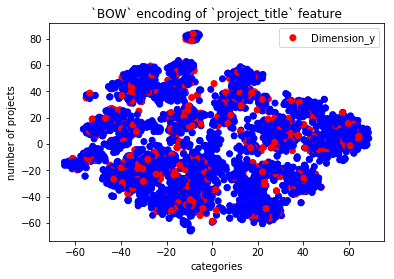

In [85]:
x =  hstack((clean_categories_one_hot, clean_subcategories_one_hot, title_bow, school_state_one_hot, project_grade_one_hot, teacher_prefix_one_hot, price_standardized.shape)
)
y = project_data['project_is_approved'].values
print(x.shape)
print(y.shape)
tsne = TSNE(n_components=2, perplexity=20, learning_rate=200)

X_embedding = tsne.fit_transform(x.toarray())
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.title("`BOW` encoding of `project_title` feature")
plt.xlabel('categories')
plt.ylabel('number of projects')
plt.legend(loc='best')
plt.show()

<h2> 2.2 TSNE with `TFIDF` encoding of `project_title` feature </h2>

In [86]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    

(5000, 480)
(5000,)


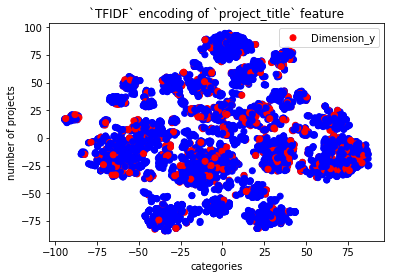

In [87]:
x =  hstack((clean_categories_one_hot, clean_subcategories_one_hot, title_tfidf, school_state_one_hot, project_grade_one_hot, teacher_prefix_one_hot, price_standardized.shape)
)
y = project_data['project_is_approved'].values
print(x.shape)
print(y.shape)
tsne = TSNE(n_components=2, perplexity=20, learning_rate=200)

X_embedding = tsne.fit_transform(x.toarray())
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.title("`TFIDF` encoding of `project_title` feature")
plt.xlabel('categories')
plt.ylabel('number of projects')
plt.legend(loc='best')
plt.show()

<h2> 2.3 TSNE with `AVG W2V` encoding of `project_title` feature </h2>

In [88]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    

(5000, 398)
(5000,)
(5000, 398)
(5000,)


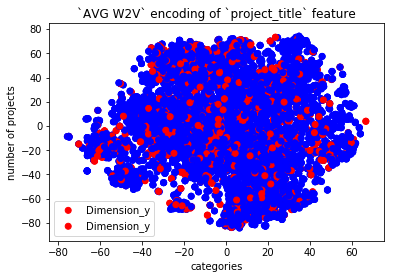

In [93]:
x =  hstack((clean_categories_one_hot, clean_subcategories_one_hot, avg_w2v_title, school_state_one_hot, project_grade_one_hot, teacher_prefix_one_hot, price_standardized.shape)
)
y = project_data['project_is_approved'].values
print(x.shape)
print(y.shape)
tsne = TSNE(n_components=2, perplexity=20, learning_rate=200)

X_embedding = tsne.fit_transform(x.toarray())
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
x =  hstack((clean_categories_one_hot, clean_subcategories_one_hot, tfidf_w2v_titles, school_state_one_hot, project_grade_one_hot, teacher_prefix_one_hot, price_standardized.shape)
)
y = project_data['project_is_approved'].values
print(x.shape)
print(y.shape)
tsne = TSNE(n_components=2, perplexity=20, learning_rate=200)

X_embedding = tsne.fit_transform(x.toarray())
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

#for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
#for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
#colors = {0:'red', 1:'blue'}
#category_to_color = {0: 'lightgreen', 1: 'lawngreen', 2:'limegreen', 3: 'darkgreen'}
category_to_label = {0: 'not approved', 1:'approved'}
#category_to_legend = {0: 'not approved', 1:'approved'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.title("`AVG W2V` encoding of `project_title` feature")
plt.xlabel('categories')
plt.ylabel('number of projects')
plt.legend(loc='best')
plt.show()

plt.show()

<h2> 2.4 TSNE with `TFIDF Weighted W2V` encoding of `project_title` feature </h2>

In [90]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    

(5000, 398)
(5000,)


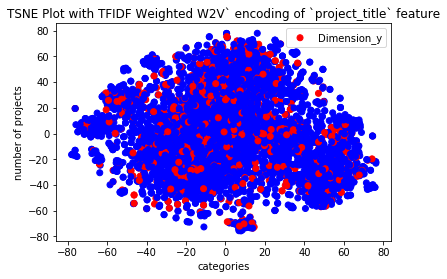

In [91]:
x =  hstack((clean_categories_one_hot, clean_subcategories_one_hot, tfidf_w2v_titles, school_state_one_hot, project_grade_one_hot, teacher_prefix_one_hot, price_standardized.shape)
)
y = project_data['project_is_approved'].values
print(x.shape)
print(y.shape)
tsne = TSNE(n_components=2, perplexity=20, learning_rate=200)

X_embedding = tsne.fit_transform(x.toarray())
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue'}
#category_to_color = {0: 'lightgreen', 1: 'lawngreen', 2:'limegreen', 3: 'darkgreen'}
category_to_label = {0: 'not approved', 1:'approved'}
#category_to_legend = {0: 'not approved', 1:'approved'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.title("TSNE Plot with TFIDF Weighted W2V` encoding of `project_title` feature")
plt.xlabel('categories')
plt.ylabel('number of projects')
plt.legend(loc='best')
plt.show()

<h2> 2.5 Summary </h2>

1. There is no clear segregation between the projects approved and those not approved.
2. We can clearly know from the above plots that the approved projects are 6 times the number of projects getting rejected.
